In [ ]:
import nibabel as nib
import numpy as np

pred = nib.load("prediction_full.nii.gz").get_fdata()
print("Unique values:", np.unique(pred))   # Harus ada [0., 1.]
print("Count of positive voxels:", np.sum(pred == 1))

Unique values: [1.74404295e-37 6.76265338e-37 2.13973607e-35 ... 9.95284736e-01
 9.95324194e-01 9.95549083e-01]
Count of positive voxels: 0


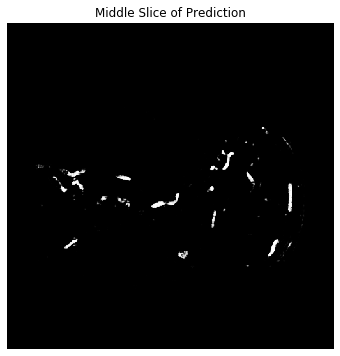

In [2]:
import matplotlib.pyplot as plt

mid = pred.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(pred[:, :, mid], cmap="gray")
plt.title("Middle Slice of Prediction")
plt.axis("off")
plt.show()

In [ ]:
from scipy.ndimage import binary_closing
import nibabel as nib
import numpy as np

# load prediksi
pred_nifti = nib.load("prediction_full.nii.gz")
pred = pred_nifti.get_fdata().astype(bool)

# morphological closing dengan kernel 3×3×3
closed = binary_closing(pred, structure=np.ones((3,3,3)))

print("Positive voxels after closing:", np.sum(closed))

# simpan kembali sebagai NIfTI
closed_nii = nib.Nifti1Image(closed.astype(np.uint8), pred_nifti.affine)
nib.save(closed_nii, "prediction_full_binclose.nii.gz")

Positive voxels after closing: 36934200


In [ ]:
import numpy as np
import nibabel as nib
from skimage import measure
import vtk
from vtk.util.numpy_support import numpy_to_vtk, numpy_to_vtkIdTypeArray

# 1. Load volume biner
nii = nib.load("prediction_full_binclose.nii.gz")
vol = nii.get_fdata().astype(np.uint8)  # shape (Z,Y,X)
affine = nii.affine

# 2. Ekstrak mesh dengan marching cubes (skimage)
verts, faces, normals, values = measure.marching_cubes(vol, level=0.5)

# 3. Siapkan vtkPoints
points = vtk.vtkPoints()
# vtkPoints expects flat array of 3D points
vtk_pts = numpy_to_vtk(verts, deep=True)
points.SetData(vtk_pts)

# 4. Siapkan vtkCellArray untuk polygons
# faces di skimage adalah (N, 3) array triad
# VTK wants one big 1D array: [3, i0, i1, i2, 3, j0, j1, j2, ...]
n_faces = faces.shape[0]
flat_faces = np.hstack([
    np.full((n_faces, 1), 3, dtype=np.int64),
    faces.astype(np.int64)
])
flat_faces = flat_faces.ravel()

cells = vtk.vtkCellArray()
# convert to vtkIdTypeArray
vtk_id_array = numpy_to_vtkIdTypeArray(flat_faces, deep=True)
cells.SetCells(n_faces, vtk_id_array)

# 5. Buat vtkPolyData
poly = vtk.vtkPolyData()
poly.SetPoints(points)
poly.SetPolys(cells)

# Optional: transfer normals
# vtk_normals = numpy_to_vtk(normals, deep=True)
# poly.GetPointData().SetNormals(vtk_normals)

# 6. Tulis ke .vtp
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName("prediction_surface_full.vtp")
# For VTK ≥9 you can do:
writer.SetInputData(poly)
# If older VTK, use writer.SetInput(poly)
writer.Write()

print("3D surface mesh (.vtp) berhasil disimpan sebagai 'prediction_surface_full.vtp'")

3D surface mesh (.vtp) berhasil disimpan sebagai 'prediction_surface_full.vtp'


In [2]:
import numpy as np
import nibabel as nib
from skimage import measure
import vtk
from vtk.util.numpy_support import numpy_to_vtk, numpy_to_vtkIdTypeArray

# 1. Load volume biner
nii = nib.load("G:/KULIAH/SEM7/IEEE-Journal/merged_aneurysm_vessel_roi_postproc.nii.gz")
vol = nii.get_fdata().astype(np.uint8)  # (Z, Y, X)

# 2. Ekstrak mesh dengan marching cubes (skimage)
verts, faces, normals, values = measure.marching_cubes(vol, level=0.5)

# 3. Siapkan vtkPoints & vtkCellArray
points = vtk.vtkPoints()
points.SetData(numpy_to_vtk(verts, deep=True))

n_faces = faces.shape[0]
flat_faces = np.hstack([
    np.full((n_faces, 1), 3, dtype=np.int64),
    faces.astype(np.int64)
]).ravel()
cells = vtk.vtkCellArray()
cells.SetCells(n_faces, numpy_to_vtkIdTypeArray(flat_faces, deep=True))

poly = vtk.vtkPolyData()
poly.SetPoints(points)
poly.SetPolys(cells)

# 4. Smoothing filter
smoother = vtk.vtkSmoothPolyDataFilter()
smoother.SetInputData(poly)
smoother.SetNumberOfIterations(50)       # coba 20–100
smoother.SetRelaxationFactor(0.1)        # antara 0 (tidak smoothing) sampai 1
smoother.FeatureEdgeSmoothingOff()       # matikan edge preservation
smoother.BoundarySmoothingOn()           # smoothing di boundary juga
smoother.Update()

smoothed_poly = smoother.GetOutput()

# 5. (Opsional) Laplacian smoother alternatif:
# laplacian = vtk.vtkWindowedSincPolyDataFilter()
# laplacian.SetInputData(poly)
# laplacian.SetNumberOfIterations(20)
# laplacian.BoundarySmoothingOn()
# laplacian.FeatureEdgeSmoothingOn()
# laplacian.Update()
# smoothed_poly = laplacian.GetOutput()

# 6. Tulis ke .vtp
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName("G:/KULIAH/SEM7/IEEE-Journal/merged_aneurysm_vessel_roi_postproc.vtp")
writer.SetInputData(smoothed_poly)
writer.Write()

print("Mesh dengan smoothing berhasil disimpan sebagai 'G:/KULIAH/SEM7/IEEE-Journal/merged_aneurysm_vessel_roi_postproc.vtp'")


Mesh dengan smoothing berhasil disimpan sebagai 'G:/KULIAH/SEM7/IEEE-Journal/merged_aneurysm_vessel_roi_postproc.vtp'
